In [ ]:
# Plan: compute spectrograms of A and C, do 1D OT frame by frame

In [1]:
import librosa
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot

# On gaussians

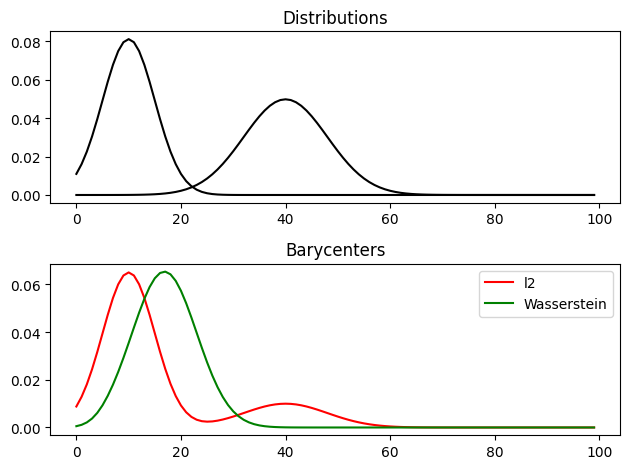

(100,)


In [533]:
n = 100  # nb bins

# bin positions
x = np.arange(n, dtype=np.float64)

# Gaussian distributions
a1 = ot.datasets.make_1D_gauss(n, m=10, s=5)  # m= mean, s= std
a2 = ot.datasets.make_1D_gauss(n, m=40, s=8)

# creating matrix A containing all distributions
A = np.vstack((a1, a2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = ot.utils.dist0(n)
M /= M.max()

alpha = 0.2  # 0<=alpha<=1
weights = np.array([1 - alpha, alpha])

# l2bary
bary_l2 = A.dot(weights)

# wasserstein
reg = 1e-3
bary_wass = ot.bregman.barycenter(A, M, reg, weights)

f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, num=1)
ax1.plot(x, A, color="black")
ax1.set_title('Distributions')

ax2.plot(x, bary_l2, 'r', label='l2')
ax2.plot(x, bary_wass, 'g', label='Wasserstein')
ax2.set_title('Barycenters')

plt.legend()
plt.show()

print(a1.shape)

# On a pure signal

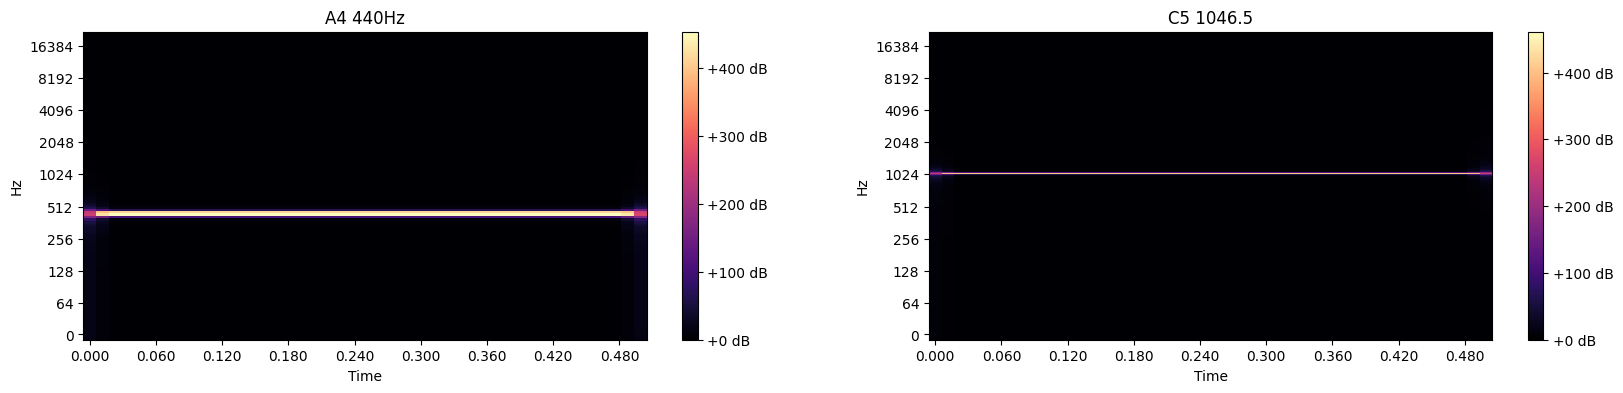

In [420]:
# Create 440Hz (A4) and 1046.5 (C5) sine waves

sr = 44100
duration = 0.5
frames = np.arange(duration * sr) / sr

A4_freq = 440
A4_signal = np.sin(2 * np.pi * A4_freq * frames)

C5_freq = 1046.5
C5_signal = np.sin(2 * np.pi * C5_freq * frames)

n_fft = 2048
A4_fft = librosa.stft(A4_signal, n_fft=n_fft)
C5_fft = librosa.stft(C5_signal, n_fft=n_fft)

fig, ax = plt.subplots(1,2, figsize=(20,4))
img_A4 = librosa.display.specshow(np.abs(A4_fft), y_axis='log', x_axis='time', ax=ax[0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
img_C5 = librosa.display.specshow(np.abs(C5_fft), y_axis='log', x_axis='time', ax=ax[1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
ax[0].set_title('A4 440Hz')
ax[1].set_title('C5 1046.5')
fig.colorbar(img_A4, ax=ax[0], format="%+2.0f dB")
fig.colorbar(img_C5, ax=ax[1], format="%+2.0f dB")

In [421]:
n = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
M = ot.utils.dist0(len(n))
M /= M.max()

A4_abs = np.abs(A4_fft)
C5_abs = np.abs(C5_fft)

B_wass = []
B_L2 = []

alpha = 0.5
reg = 3e-6

for index in range(A4_fft.shape[1]):

    A4_norm = A4_abs[:, index]
    A4_norm /= np.sum(A4_norm)
    C5_norm = C5_abs[:, index]
    C5_norm /= np.sum(C5_norm)

    A = np.vstack((A4_norm, C5_norm)).T
    weights = np.array([1 - alpha, alpha])

    B_L2.append(A.dot(weights))

    # wasserstein
    B_wass.append(ot.bregman.barycenter(A, M, reg, weights))


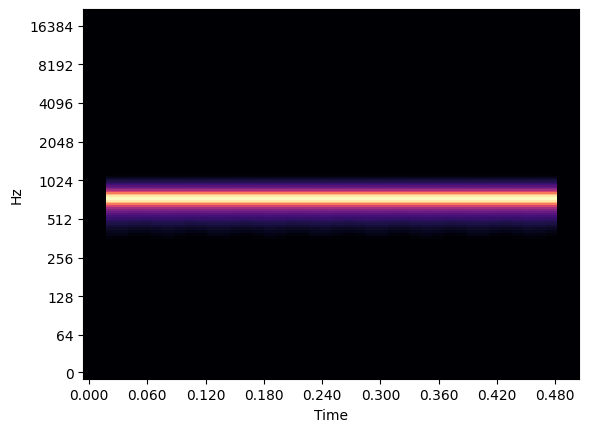

In [426]:
B = np.array(B_wass).T
for i in range(len(B)): # set nan entries to zero
    for j in range(len(B[i])):
        if B[i][j] != B[i][j]:
            B[i][j] = 0

librosa.display.specshow(librosa.amplitude_to_db(B, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4)
plt.show()

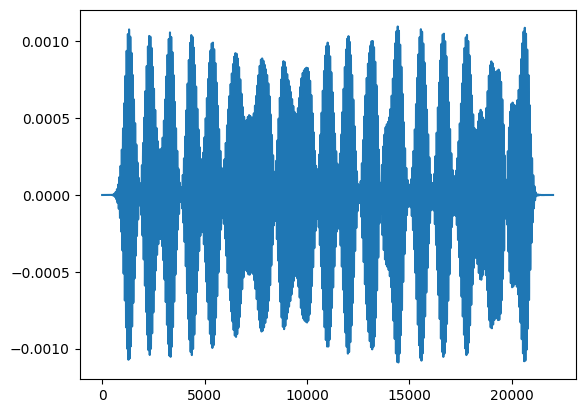

In [432]:
interpolated_signal = librosa.griffinlim(B, n_iter = 100, n_fft=n_fft)

interpolated_signal = ((1 - alpha)*np.max(A4_signal) + alpha*np.max(C5_signal)) * interpolated_signal / np.max(interpolated_signal)
plt.plot(interpolated_signal)
IPython.display.Audio(data=interpolated_signal, rate=sr) # lol

# On a real signal

C:\Users\David\AppData\Local\Temp\ipykernel_11056\3885026565.py:11: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(A_stft, ref=np.max), y_axis='log', x_axis='time', ax=axs[0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
C:\Users\David\AppData\Local\Temp\ipykernel_11056\3885026565.py:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(C_stft, ref=np.max), y_axis='log', x_axis='time', ax=axs[1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)


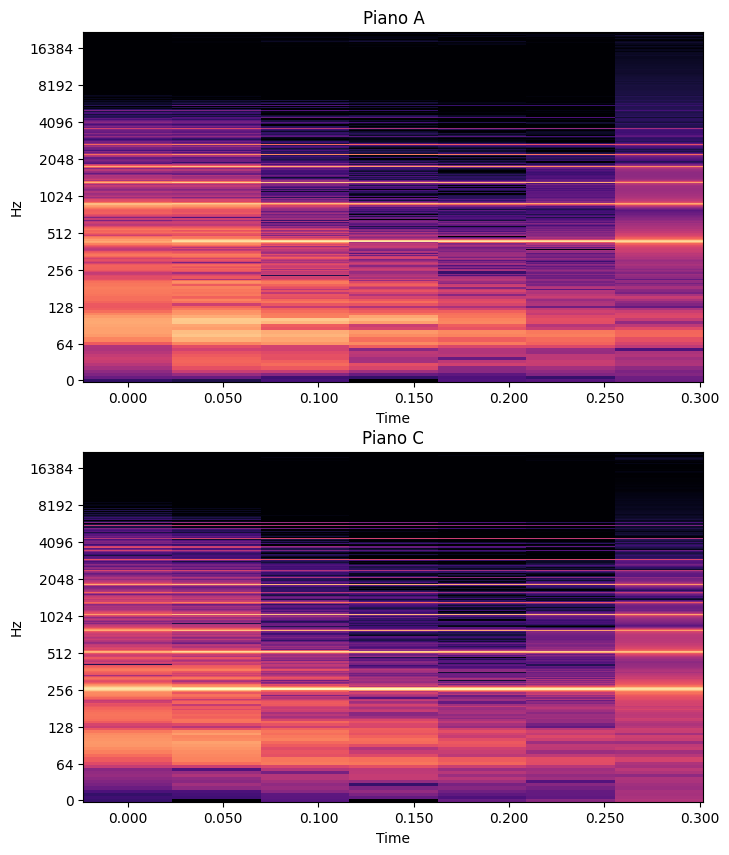

In [470]:
duration = 0.3 # in seconds

A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)

n_fft = 8192
A_stft = librosa.stft(A_signal, n_fft=n_fft)
C_stft = librosa.stft(C_signal, n_fft=n_fft)

fig, axs = plt.subplots(2,1, figsize=(8, 10))
librosa.display.specshow(librosa.amplitude_to_db(A_stft, ref=np.max), y_axis='log', x_axis='time', ax=axs[0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(librosa.amplitude_to_db(C_stft, ref=np.max), y_axis='log', x_axis='time', ax=axs[1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
axs[0].set_title(f"Piano A")
axs[1].set_title(f"Piano C")
plt.show()

IPython.display.Audio(data=C_signal, rate=sr) # lol


In [481]:
n = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
M = ot.utils.dist0(len(n))
M /= M.max()

A_abs = np.abs(A_stft)
C_abs = np.abs(C_stft)

B_wass = []
B_L2 = []

alpha = 0.5
reg = 5e-4

for index in range(A_abs.shape[1]):

    if(index % 1 == 0):
        print(index)

    A_norm = A_abs[:, index]
    A_norm /= np.sum(A_norm)
    C_norm = C_abs[:, index]
    C_norm /= np.sum(C_norm)

    A = np.vstack((A_norm, C_norm)).T
    weights = np.array([1 - alpha, alpha])

    B_L2.append(A.dot(weights))

    # wasserstein
    B_wass.append(ot.bregman.barycenter(A, M, reg, weights))


0


KeyboardInterrupt: 

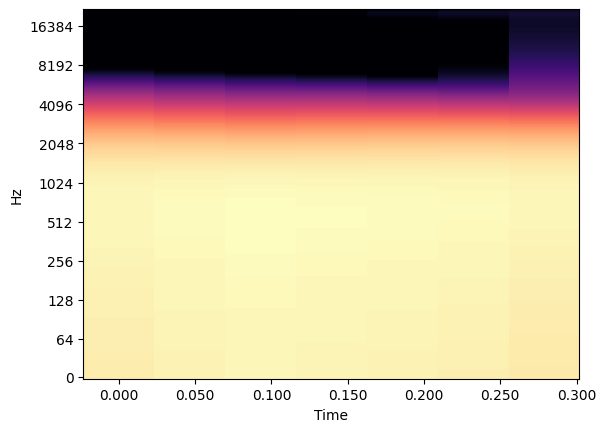

In [476]:
B = np.array(B_wass).T
for i in range(len(B)): # set nan entries to zero
    for j in range(len(B[i])):
        if B[i][j] != B[i][j]:
            B[i][j] = 0

librosa.display.specshow(librosa.amplitude_to_db(B, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4)
plt.show()

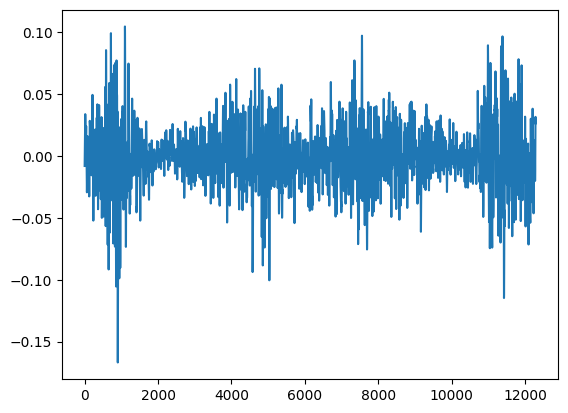

In [477]:
interpolated_signal = librosa.griffinlim(B, n_iter = 100, n_fft=n_fft)

interpolated_signal = ((1 - alpha)*np.max(A_signal) + alpha*np.max(C_signal)) * interpolated_signal / np.max(interpolated_signal)
plt.plot(interpolated_signal)
IPython.display.Audio(data=interpolated_signal, rate=sr) # lol

In [514]:
# unbalanced

n = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
M = ot.utils.dist0(len(n))
M /= M.max()

A_abs = np.abs(A_stft)
C_abs = np.abs(C_stft)

B_wass = []
B_L2 = []

alpha = 0.5
reg = 5e-7
epsilon = 1e-6

for index in range(A_abs.shape[1]):

    if(index % 1 == 0):
        print(index)

    A_norm = A_abs[:, index]
    C_norm = C_abs[:, index]

    A = np.vstack((A_norm, C_norm)).T
    weights = np.array([1 - alpha, alpha])

    B_L2.append(A.dot(weights))

    # wasserstein
    B_wass.append(ot.unbalanced.barycenter_unbalanced_stabilized(A, M, epsilon, reg, weights=weights))


0
1
2
3
4
5
6


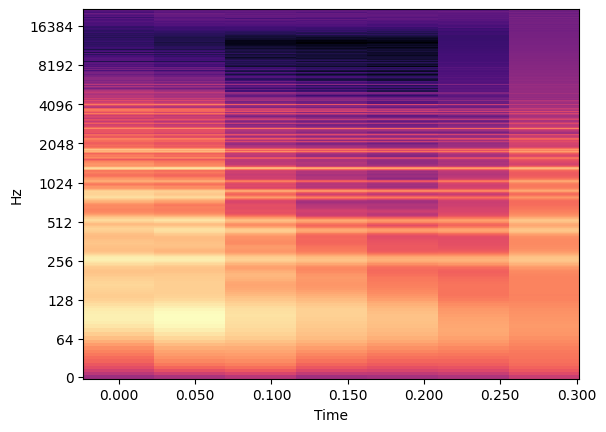

In [520]:
B = np.array(B_wass).T
for i in range(len(B)): # set nan entries to zero
    for j in range(len(B[i])):
        if B[i][j] != B[i][j]:
            B[i][j] = 0

librosa.display.specshow(librosa.amplitude_to_db(B, ref=np.max), y_axis='log', x_axis='time', sr=sr, n_fft=n_fft, hop_length=n_fft//4)
plt.show()

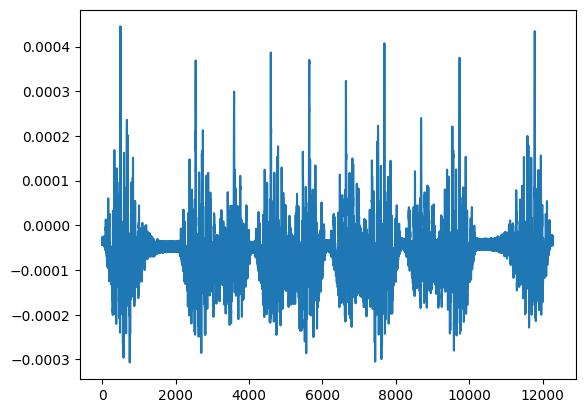

In [521]:
# interpolated_signal = librosa.griffinlim(B, n_iter = 100, n_fft=n_fft)
S = B * ((1-alpha)* A_abs / np.abs(A_abs)  + alpha * C_abs / np.abs(C_abs))
interpolated_signal = librosa.istft(S)

# interpolated_signal = ((1 - alpha)*np.max(A_signal) + alpha*np.max(C_signal)) * interpolated_signal / np.max(interpolated_signal)
plt.plot(interpolated_signal)
IPython.display.Audio(data=interpolated_signal, rate=sr) # lol